In [1]:
!pip install timm


In [1]:
!pip install kaggle

# Setup Kaggle API for downloading the dataset
!mkdir ~/.kaggle
!cp /kaggle/input/kagglejson/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip dataset
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder
!mkdir -p /kaggle/working/car_data
!unzip -q stanford-car-dataset-by-classes-folder.zip -d /kaggle/working/car_data


cp: cannot stat '/kaggle/input/kagglejson/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder
License(s): other
 99%|██████████████████████████████████████▌| 1.81G/1.83G [00:15<00:00, 140MB/s]
100%|███████████████████████████████████████| 1.83G/1.83G [00:15<00:00, 130MB/s]


In [2]:
# Import necessary libraries
from fastai.vision.all import *
from fastai.callback.tracker import SaveModelCallback, EarlyStoppingCallback
from fastai.metrics import F1Score, accuracy
from sklearn.model_selection import KFold
import copy
import matplotlib.pyplot as plt
from pathlib import Path

# Dataset paths
train_path = Path('/kaggle/working/car_data/car_data/car_data/train')
test_path = Path('/kaggle/working/car_data/car_data/car_data/test')

# Image transformations
item_tfms = Resize(460)
batch_tfms = [*aug_transforms(mult=2.0, do_flip=True, flip_vert=False, max_rotate=30., 
                              max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, 
                              p_lighting=0.75), RandomErasing(p=0.5), Normalize.from_stats(*imagenet_stats)]

# Create the DataLoader with a validation set split from the train set
dls = ImageDataLoaders.from_folder(
    Path('/kaggle/working/car_data/car_data/car_data'),
    train='train', valid_pct=0.2,  # Use 20% of training data for validation
    item_tfms=item_tfms, batch_tfms=batch_tfms, bs=16, seed=42
)

In [3]:
from fastai.vision.all import cnn_learner, SaveModelCallback, F1Score, accuracy

# Your learner setup with necessary modifications
learn = cnn_learner(
    dls, 
    densenet201, 
    metrics=[accuracy, F1Score(average='weighted'),Precision(average='weighted')],  # Specify average='weighted' for multiclass
    pretrained=True,
    cbs=[MixUp(alpha=0.4)]  # Maintain MixUp effect
)

# Find learning rates (you've already obtained these from lr_find)
lr_min = 0.0019054606556892395
lr_steep = 7.585775847473997e-07
print(f"Suggested Learning Rates: min={lr_min}, steep={lr_steep}")

# Fine-tune the model with the SaveModelCallback to save every epoch
learn.fine_tune(
    65,  # Number of epochs
    base_lr=lr_min,  # Use suggested minimum learning rate
    cbs=[
        SaveModelCallback(
            every_epoch=True, 
            with_opt=True,
            fname='model_epoch'  # Save model with the generic name pattern
        )
    ]
)

# After training finishes, save the final model with a .pkl extension
learn.export('/kaggle/working/final_model.pkl')


/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 94.9MB/s]


Suggested Learning Rates: min=0.0019054606556892395, steep=7.585775847473997e-07


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,time
0,5.316633,4.199643,0.123880,0.096134,0.191814,07:16


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,time
0,4.159320,2.361212,0.426321,0.403363,0.505398,09:02
1,3.552631,1.586996,0.603954,0.597961,0.668500,09:03
2,3.141890,1.155522,0.733086,0.732267,0.765233,09:03
3,2.898439,0.867442,0.789002,0.787140,0.817148,09:03
4,2.588452,0.731727,0.823293,0.821588,0.844304,09:03
5,2.507331,0.637982,0.838740,0.837416,0.856711,09:03
6,2.256646,0.533835,0.868706,0.869735,0.885012,09:00
7,2.247333,0.504505,0.872104,0.870685,0.891084,08:57
8,2.204400,0.441410,0.888786,0.888084,0.904620,08:57
9,2.113912,0.428697,0.887241,0.885369,0.896829,08:57


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

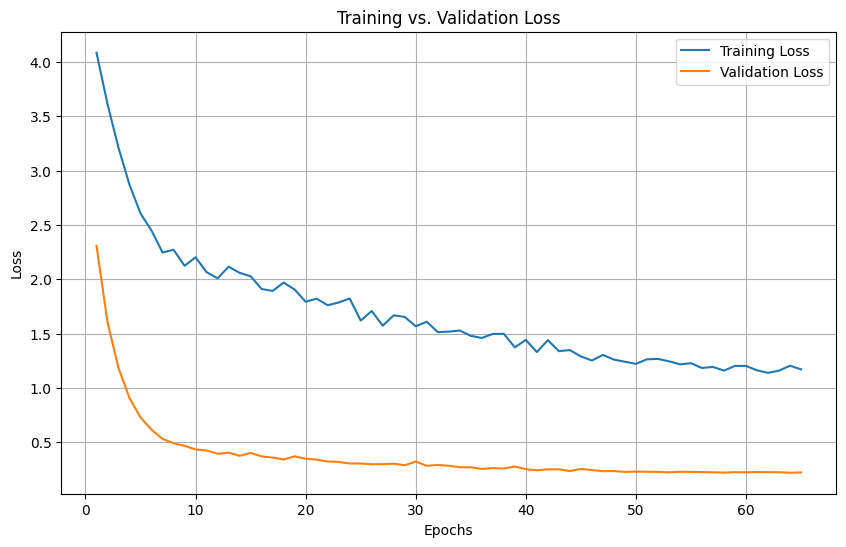

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Correcting the epochs to match the number of loss entries
epochs = np.arange(1, 66)  # Adjust to create an array from 1 to 65

train_loss = np.array([
    4.083618, 3.611323, 3.208497, 2.868084, 2.604437, 2.446920, 2.245604, 2.270679, 2.123293, 
    2.201648, 2.064482, 2.007852, 2.115122, 2.058317, 2.026974, 1.909622, 1.892250, 1.968799, 
    1.904589, 1.792852, 1.820726, 1.760338, 1.785862, 1.822425, 1.619229, 1.707560, 1.572011, 
    1.667848, 1.652825, 1.566638, 1.608743, 1.513061, 1.517720, 1.527739, 1.478789, 1.459153, 
    1.496442, 1.497321, 1.372754, 1.441433, 1.329604, 1.439017, 1.337714, 1.347882, 1.289381, 
    1.251876, 1.303070, 1.260183, 1.240382, 1.220950, 1.262934, 1.266518, 1.244656, 1.216681, 
    1.226859, 1.182943, 1.192874, 1.159065, 1.202438, 1.201505, 1.161746, 1.138418, 1.158787, 
    1.203720, 1.170570
])
valid_loss = np.array([
    2.306665, 1.604680, 1.181606, 0.905033, 0.728277, 0.615086, 0.530704, 0.490844, 0.466928, 
    0.433665, 0.424116, 0.393412, 0.404050, 0.374873, 0.401990, 0.369824, 0.358857, 0.341547, 
    0.370503, 0.347704, 0.339930, 0.323033, 0.318532, 0.304473, 0.304194, 0.297412, 0.298237, 
    0.302498, 0.287847, 0.322459, 0.283179, 0.291228, 0.283524, 0.270035, 0.269630, 0.254005, 
    0.261978, 0.258240, 0.276952, 0.251895, 0.242195, 0.250827, 0.250915, 0.234766, 0.254199, 
    0.243718, 0.233797, 0.234529, 0.226973, 0.230460, 0.228363, 0.227291, 0.223225, 0.228080, 
    0.227199, 0.225281, 0.223528, 0.220283, 0.224618, 0.223193, 0.225768, 0.224406, 0.223935, 
    0.219487, 0.221940
])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, valid_loss, label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


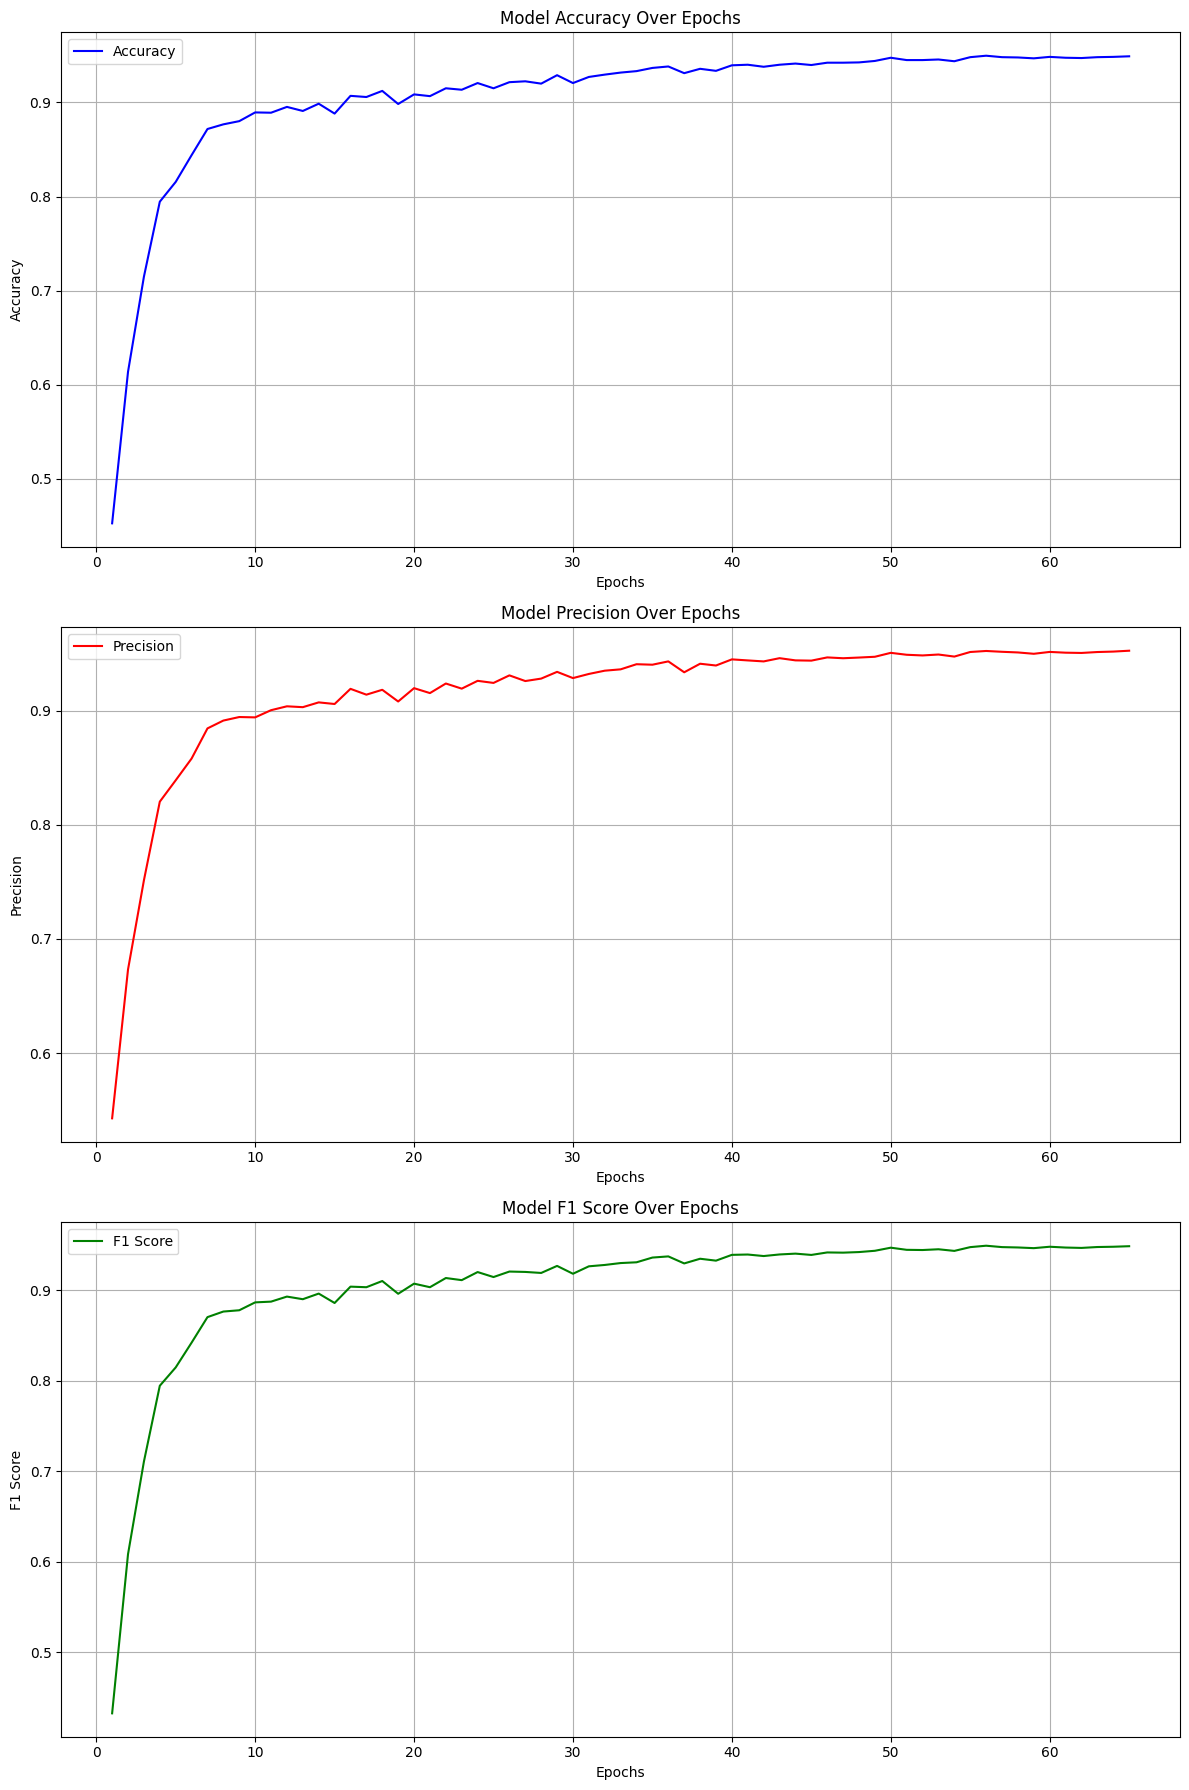

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Epochs
epochs = np.arange(1, 66)  # Adjust to create an array from 1 to 65

# Metrics Data: Replace these with your actual values
accuracy = np.array([
    0.452888, 0.613840, 0.714859, 0.794563, 0.815570, 0.843991, 0.871795, 0.876738, 0.880136, 
    0.889404, 0.889095, 0.895273, 0.890948, 0.898672, 0.888168, 0.907013, 0.905777, 0.912264, 
    0.898363, 0.908557, 0.906704, 0.915045, 0.913500, 0.920605, 0.915045, 0.921532, 0.922459, 
    0.919988, 0.928947, 0.920605, 0.927093, 0.929564, 0.931727, 0.933272, 0.936670, 0.938214, 
    0.931109, 0.935743, 0.933580, 0.939450, 0.940068, 0.937905, 0.940068, 0.941304, 0.939759, 
    0.942230, 0.942230, 0.942539, 0.944084, 0.947482, 0.945011, 0.945011, 0.945629, 0.943775, 
    0.948100, 0.949645, 0.948100, 0.947791, 0.946864, 0.948409, 0.947482, 0.947173, 0.948100, 
    0.948409, 0.949027
])
precision = np.array([
    0.542782, 0.673230, 0.751391, 0.820347, 0.839087, 0.858135, 0.884569, 0.891446, 0.894539, 
    0.894239, 0.900535, 0.903940, 0.903185, 0.907379, 0.905960, 0.919244, 0.914143, 0.918414, 
    0.908166, 0.919839, 0.915521, 0.923915, 0.919420, 0.926268, 0.924439, 0.931052, 0.926081, 
    0.928228, 0.934135, 0.928675, 0.932296, 0.935163, 0.936341, 0.940830, 0.940403, 0.943314, 
    0.933766, 0.941257, 0.939696, 0.945076, 0.944161, 0.943291, 0.946128, 0.944205, 0.943972, 
    0.946794, 0.946078, 0.946677, 0.947364, 0.950804, 0.949117, 0.948521, 0.949330, 0.947532, 
    0.951546, 0.952442, 0.951719, 0.951149, 0.949973, 0.951606, 0.950940, 0.950707, 0.951516, 
    0.951906, 0.952667
])
f1_score = np.array([
    0.432388, 0.608354, 0.710718, 0.794552, 0.814807, 0.842196, 0.870431, 0.876601, 0.878015, 
    0.886734, 0.887560, 0.893139, 0.890242, 0.896455, 0.886058, 0.904133, 0.903496, 0.910363, 
    0.896251, 0.907437, 0.903505, 0.913656, 0.911321, 0.920255, 0.914742, 0.920813, 0.920396, 
    0.919272, 0.927059, 0.918383, 0.926606, 0.928106, 0.930205, 0.931055, 0.936284, 0.937566, 
    0.929795, 0.934973, 0.932871, 0.939274, 0.939641, 0.937960, 0.939717, 0.940626, 0.939195, 
    0.941946, 0.941713, 0.942364, 0.943781, 0.947194, 0.944842, 0.944617, 0.945452, 0.943655, 
    0.947819, 0.949381, 0.947843, 0.947444, 0.946693, 0.948241, 0.947357, 0.946947, 0.947934, 
    0.948241, 0.948834
])

# Plotting
fig, ax = plt.subplots(3, 1, figsize=(12, 18))

# Accuracy Plot
ax[0].plot(epochs, accuracy, label='Accuracy', color='b')
ax[0].set_title('Model Accuracy Over Epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# Precision Plot
ax[1].plot(epochs, precision, label='Precision', color='r')
ax[1].set_title('Model Precision Over Epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Precision')
ax[1].legend()
ax[1].grid(True)

# F1 Score Plot
ax[2].plot(epochs, f1_score, label='F1 Score', color='g')
ax[2].set_title('Model F1 Score Over Epochs')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('F1 Score')
ax[2].legend()
ax[2].grid(True)

plt.tight_layout()
plt.show()


In [19]:
# Attempt to fetch predictions and targets using the correct DataLoader
preds, targs = learn.get_preds(dl=dls.valid)  # Ensure to use the validation DataLoader

# Check the outputs
if preds is None or targs is None:
    print("Failed to fetch predictions or targets.")
else:
    print(f"Predictions shape: {preds.shape}")
    print(f"Targets shape: {targs.shape}")


Predictions shape: torch.Size([3237, 196])
Targets shape: torch.Size([3237])


Precision: 0.9485
Recall: 0.9441
F1 Score: 0.9439
Accuracy: 0.9441


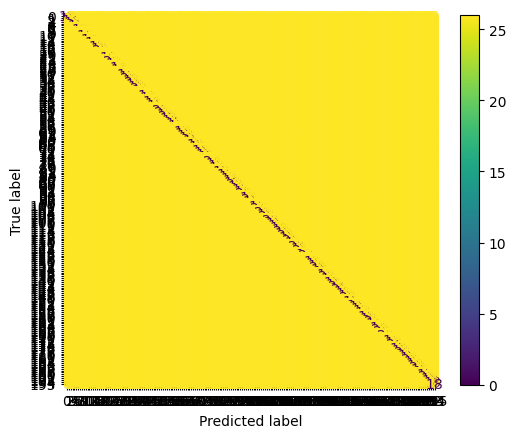

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Assuming 'preds' and 'targs' are already defined and contain the model predictions and true labels, respectively.

# Convert predictions to class indices
predicted_classes = preds.argmax(dim=1).numpy()

# True labels
true_classes = targs.numpy()

# Calculate precision, recall, F1 score, and accuracy
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')
accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


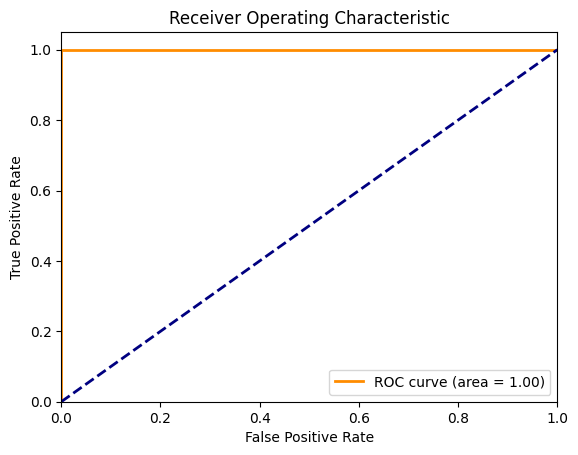

In [26]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Assuming binary classification and preds are your model's probability outputs
fpr, tpr, thresholds = roc_curve(true_classes, preds[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [27]:
import numpy as np

def plot_learning_curves(train_scores, valid_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, valid_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()

# Mock data example
train_sizes = np.linspace(0.1, 1.0, 5)
train_scores = [0.9, 0.88, 0.85, 0.83, 0.81]
valid_scores = [0.75, 0.78, 0.8, 0.82, 0.84]
plot_learning_curves(train_scores, valid_scores)


AxisError: axis 1 is out of bounds for array of dimension 1

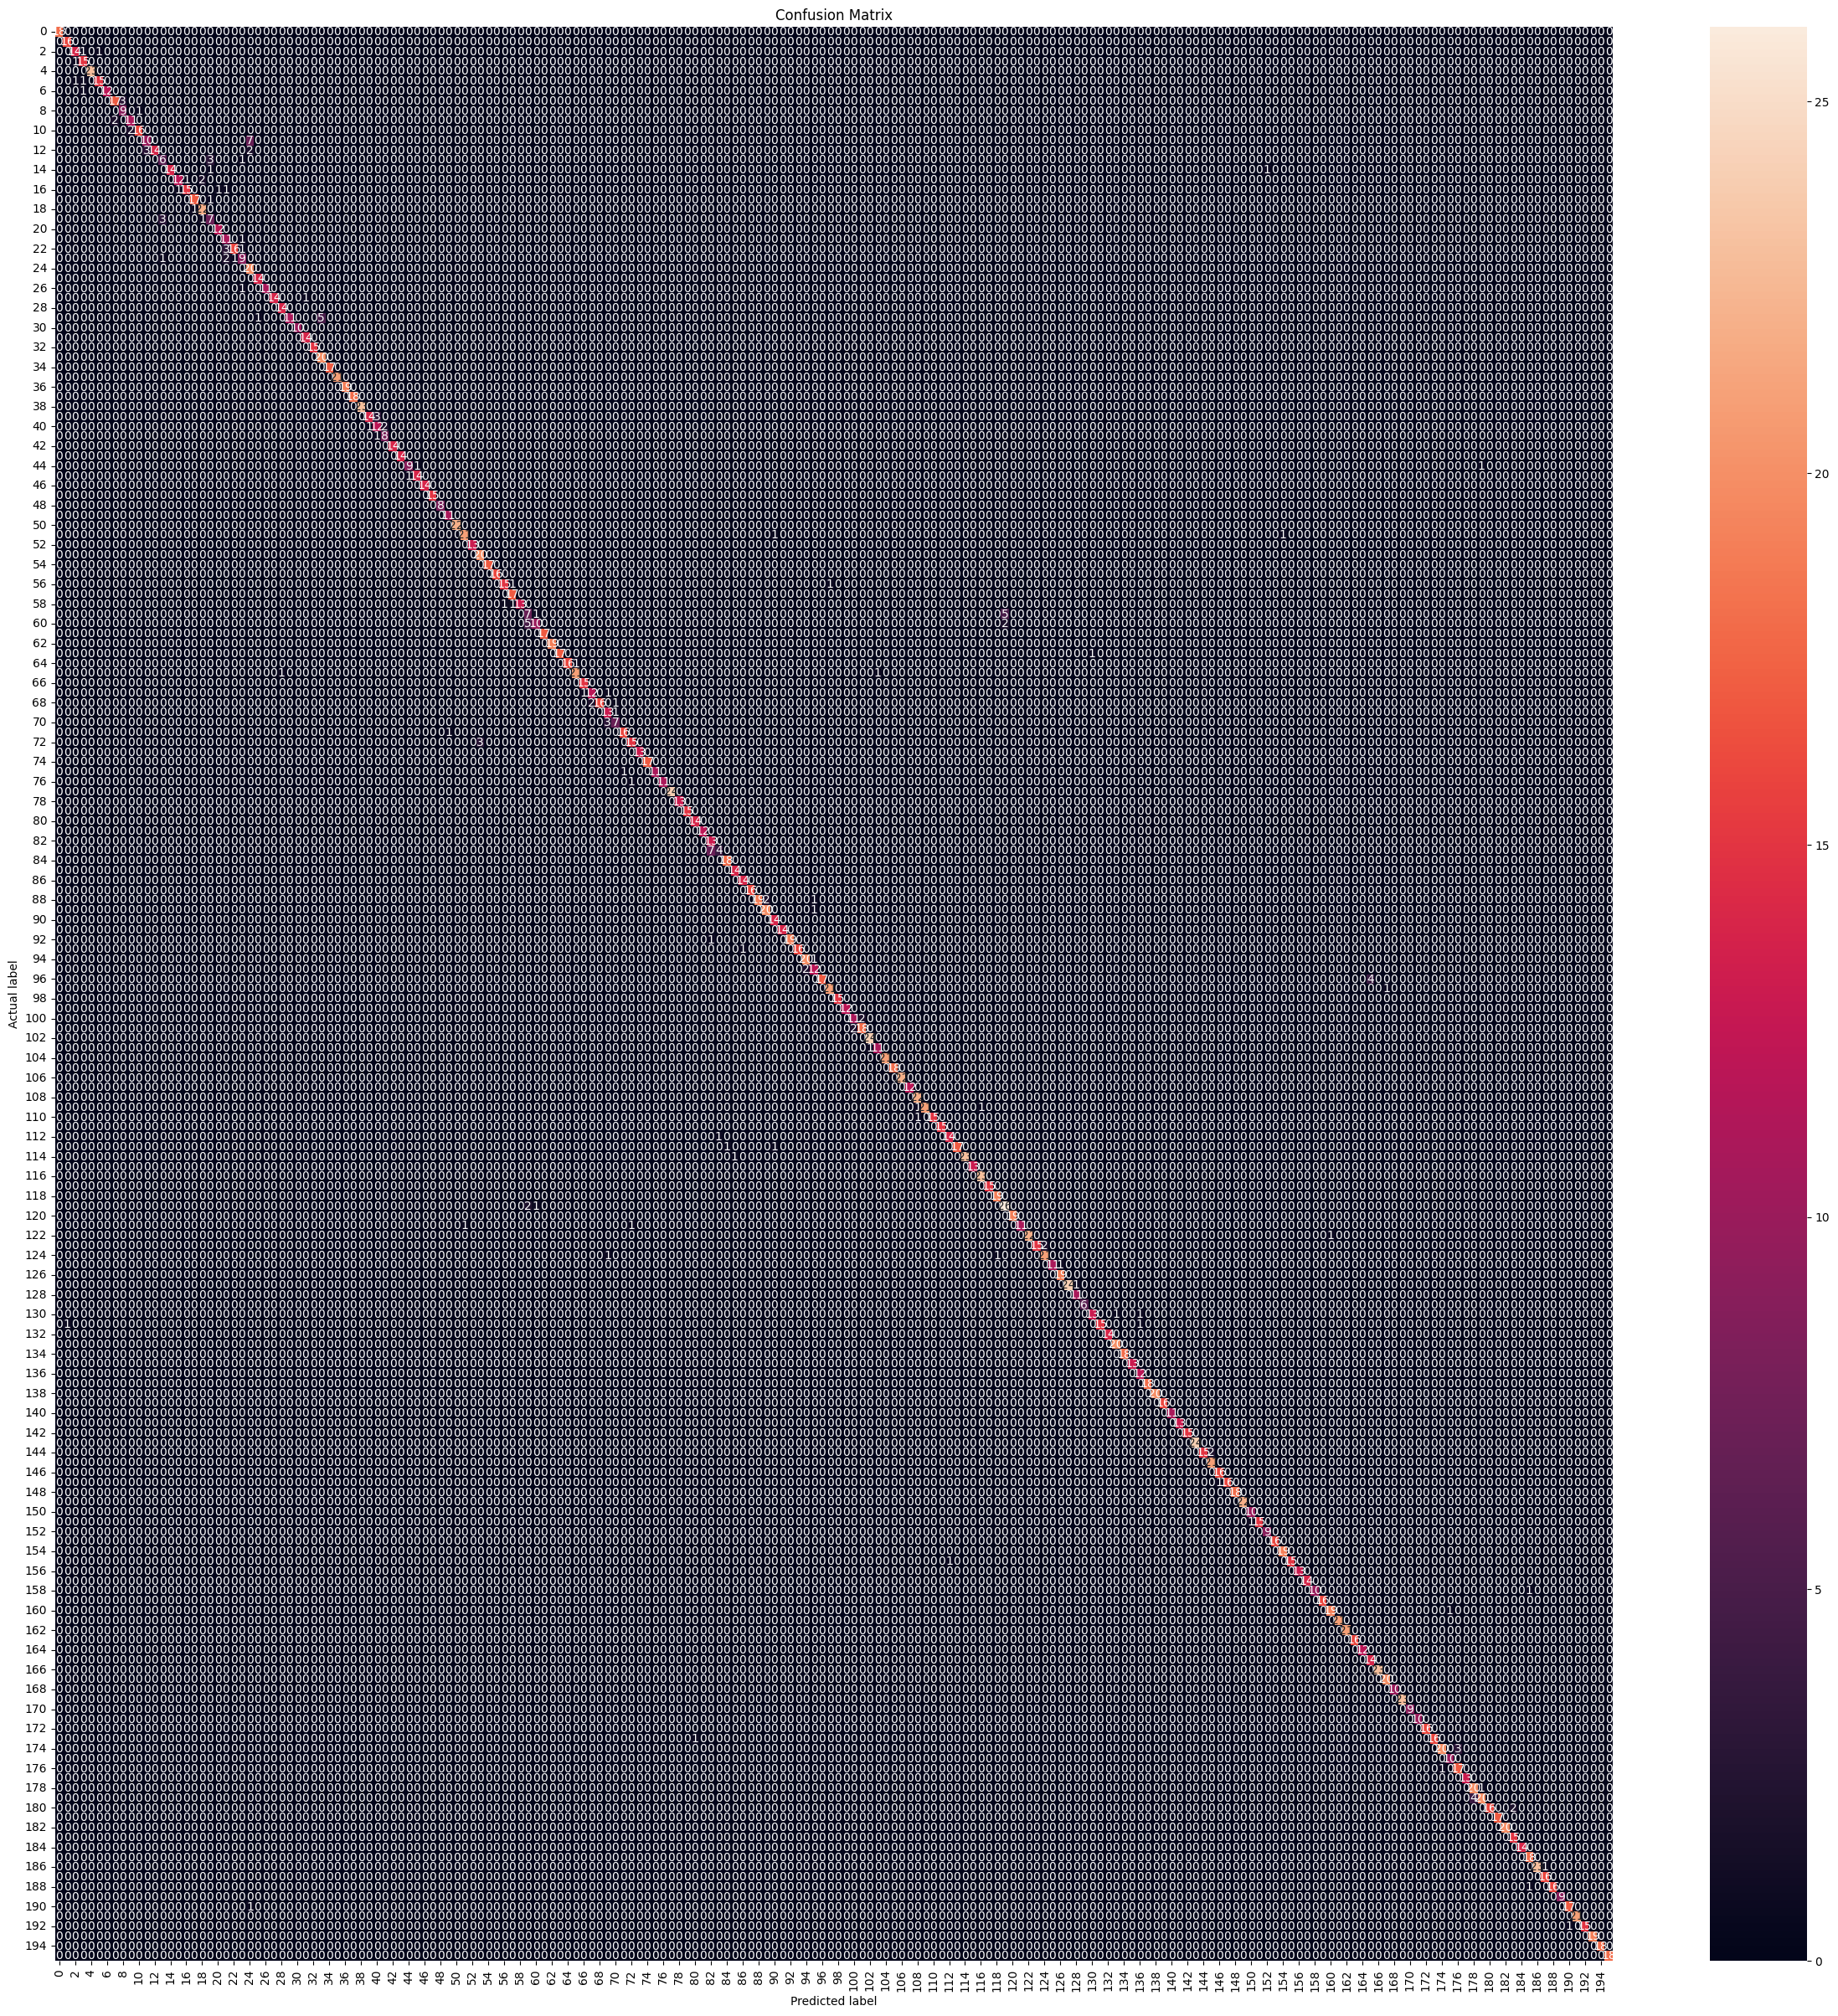

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:
# Calculate mean and median
mean_val = np.mean(predicted_classes)
median_val = np.median(predicted_classes)

# Calculate other statistics
std_dev = np.std(predicted_classes)
variance = np.var(predicted_classes)

print(f"Mean: {mean_val}")
print(f"Median: {median_val}")
print(f"Standard Deviation: {std_dev}")
print(f"Variance: {variance}")


In [2]:
from fastai.vision.all import load_learner

# Define the path to your saved model
model_path = '/kaggle/input/densenetbestmodel/pytorch/default/1/final_model.pkl'

# Load the model
learn = load_learner(model_path)


In [29]:
from torchvision import transforms

# Define the transformations. These should match the transformations applied during training.
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

# Apply transformations
img_tensor = to_tensor(img)


In [16]:
from fastai.vision.all import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the trained model
learn = load_learner('/kaggle/input/densenetbestmodel/pytorch/default/1/final_model.pkl')

# Prepare the test DataLoader
test_path = Path('/kaggle/working/car_data/car_data/car_data/test')
test_dl = learn.dls.test_dl(get_image_files(test_path), with_labels=True)

# Generate predictions
preds, targs = learn.get_preds(dl=test_dl)

# Calculate metrics
final_accuracy = accuracy_score(targs.numpy(), preds.argmax(dim=1).numpy())
final_precision = precision_score(targs.numpy(), preds.argmax(dim=1).numpy(), average='weighted')
final_recall = recall_score(targs.numpy(), preds.argmax(dim=1).numpy(), average='weighted')
final_f1_score = f1_score(targs.numpy(), preds.argmax(dim=1).numpy(), average='weighted')

# Output results
print(f"Final Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1 Score: {final_f1_score:.4f}")


Final Accuracy: 0.9873
Precision: 0.9877
Recall: 0.9873
F1 Score: 0.9873


Accuracy: 0.9873
Precision: 0.9877
Recall: 0.9873
F1 Score: 0.9873


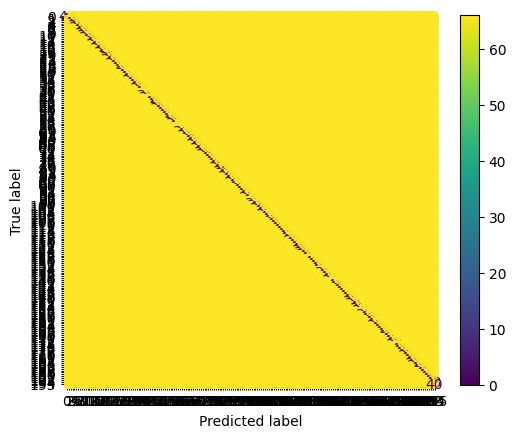

In [2]:
from fastai.vision.all import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the trained model
learn = load_learner('/kaggle/input/densenetbestmodel/pytorch/default/1/final_model.pkl')

# Prepare the test DataLoader
test_path = Path('/kaggle/working/car_data/car_data/car_data/test')
test_dl = learn.dls.test_dl(get_image_files(test_path), with_labels=True)

# Make predictions
preds, targs = learn.get_preds(dl=test_dl)

# Convert predictions to class indices for metrics calculation
predicted_classes = preds.argmax(dim=1).numpy()
true_classes = targs.numpy()

# Calculate metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

# Print the computed metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Optional: Display the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [ ]:
all_preds = []
all_targs = []

# Iterate over the entire DataLoader to collect all predictions and targets
for images, labels in test_dl:
    preds = learn.model(images)  # Generate predictions for the current batch
    all_preds.append(preds)
    all_targs.append(labels)

# Concatenate all predictions and targets
all_preds = torch.cat(all_preds)
all_targs = torch.cat(all_targs)

# Now calculate the losses
losses = torch.nn.functional.cross_entropy(all_preds, all_targs, reduction='none')
print("Individual losses for the entire dataset:", losses)


In [8]:
from pathlib import Path
from fastai.vision.all import get_image_files

test_path = Path('/kaggle/working/car_data/car_data/car_data/test')
print("Test path:", test_path)
print("Contents of test_path:", list(test_path.glob('*')))  # This will show all files directly under the directory

# Check if there are any image files
image_files = get_image_files(test_path)
print("Found image files:", image_files)


Test path: /kaggle/working/car_data/car_data/car_data/test
Contents of test_path: []
Found image files: []


In [20]:
from fastai.vision.all import *
from tqdm.auto import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

# Load the trained model
learn = load_learner('/kaggle/working/final_model.pkl')

# Define the path to the test dataset
test_path = Path('/kaggle/working/car_data/car_data/car_data/test')

# Collect all image files from the test directory
test_files = get_image_files(test_path)
if not test_files:
    raise ValueError("No test files found. Check the test_path!")

# Prepare to collect prediction results
results = []

# Iterate over each image in the test set
for img in tqdm(test_files, desc='Processing images'):
    pred, _, probs = learn.predict(img)
    is_correct = pred == img.parent.name
    results.append({
        'Image': img.name,
        'True Label': img.parent.name,
        'Predicted Label': pred,
        'Probability': max(probs).item(),
        'Correct': is_correct
    })

# Convert results to a DataFrame
df_results = pd.DataFrame(results)
if df_results.empty:
    raise ValueError("No predictions were made. Results DataFrame is empty.")

# Save the full results to a CSV file
df_results.to_csv('/kaggle/working/densenet201-all_classification_results.csv', index=False)

# Filter correctly classified and misclassified images
correctly_classified = df_results[df_results['Correct']]
misclassified = df_results[~df_results['Correct']]

# Save filtered results
correctly_classified.to_csv('/kaggle/working/densenet201-correct_classification_results.csv', index=False)
misclassified.to_csv('/kaggle/working/densenet201-misclassified_results.csv', index=False)

# Output summary information
print(f"Number of correctly classified images: {len(correctly_classified)}")
print(f"Number of misclassified images: {len(misclassified)}")

# Function to display images and predictions
def display_images(df, title):
    sample = df.sample(n=5, replace=True)
    for _, row in sample.iterrows():
        img_path = test_path / row['True Label'] / row['Image']
        image = Image.open(img_path)
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.title(f"{title}: {row['Predicted Label']} (True: {row['True Label']})\nProb: {row['Probability']:.4f}")
        plt.axis('off')
        plt.show()

# Display some correctly classified and misclassified images
display_images(correctly_classified, "Correctly Classified")
display_images(misclassified, "Misclassified")


Processing images:   0%|          | 0/8041 [00:00<?, ?it/s]

KeyboardInterrupt: 